In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil import parser
import os

In [2]:
# DATA

# import

station_id=5001
file_path = os.path.join(r'D:\FMF magisterij\Matematika z računalnikom', f'ELES-MAS-{station_id}-2020-2023.csv.gz')
data = pd.read_csv(file_path, compression='gzip')
data = data[data['data_validity'] <= 32]
data.drop('measurement_location_inst_id', axis=1, inplace=True)
data['acquisition_timestamp'] = pd.to_datetime(data['acquisition_timestamp'], utc=True)

# pivoting
new_data = data.pivot_table(index='acquisition_timestamp', columns='parameter_type', values='value').reset_index()
new_data.set_index('acquisition_timestamp', inplace=True)


# ambient temperature
air_pressure = new_data[['AIR_PRESSURE']]
print(air_pressure)

# count the NaN values
nan_count_air_pressure = air_pressure['AIR_PRESSURE'].isna().sum()
print(nan_count_air_pressure)
# there are no NaN values

# check for missing measurements (skipped times)
complete_range = pd.date_range(start=air_pressure.index.min(), end=air_pressure.index.max(), freq='5T')
missing_timestamps = complete_range.difference(air_pressure.index)
print(len(missing_timestamps))
#print(complete_range)
df_complete_range = pd.DataFrame(index=complete_range)
len(df_complete_range)
# we have 271508 measurements, there are 5112 missing measurment out of 276620 time steps in the whole time range

# merge all the air pressure measurements with all the time steps. missing measurment will be NaN values for now
air_pressure_incomplete = df_complete_range.merge(air_pressure, left_index=True, right_index=True, how='left')
# print(temperature_incomplete)
air_pressure_incomplete.isna().sum() # okay

# missing measurements are filled with the next available measurement
air_pressure_all = air_pressure_incomplete.bfill()
print(air_pressure_all)
print(air_pressure_all.isna().sum()) # okay

str(air_pressure_all.index.dtype) # okay

parameter_type             AIR_PRESSURE
acquisition_timestamp                  
2020-10-13 10:20:00+00:00         952.8
2020-10-13 10:25:00+00:00         952.8
2020-10-13 10:30:00+00:00         952.8
2020-10-13 10:35:00+00:00         952.8
2020-10-13 10:40:00+00:00         952.8
...                                 ...
2023-05-31 21:35:00+00:00         964.8
2023-05-31 21:40:00+00:00         964.8
2023-05-31 21:45:00+00:00         964.9
2023-05-31 21:50:00+00:00         964.9
2023-05-31 21:55:00+00:00         964.9

[271508 rows x 1 columns]
0
5112
                           AIR_PRESSURE
2020-10-13 10:20:00+00:00         952.8
2020-10-13 10:25:00+00:00         952.8
2020-10-13 10:30:00+00:00         952.8
2020-10-13 10:35:00+00:00         952.8
2020-10-13 10:40:00+00:00         952.8
...                                 ...
2023-05-31 21:35:00+00:00         964.8
2023-05-31 21:40:00+00:00         964.8
2023-05-31 21:45:00+00:00         964.9
2023-05-31 21:50:00+00:00         964.9
2023-0

'datetime64[ns, UTC]'

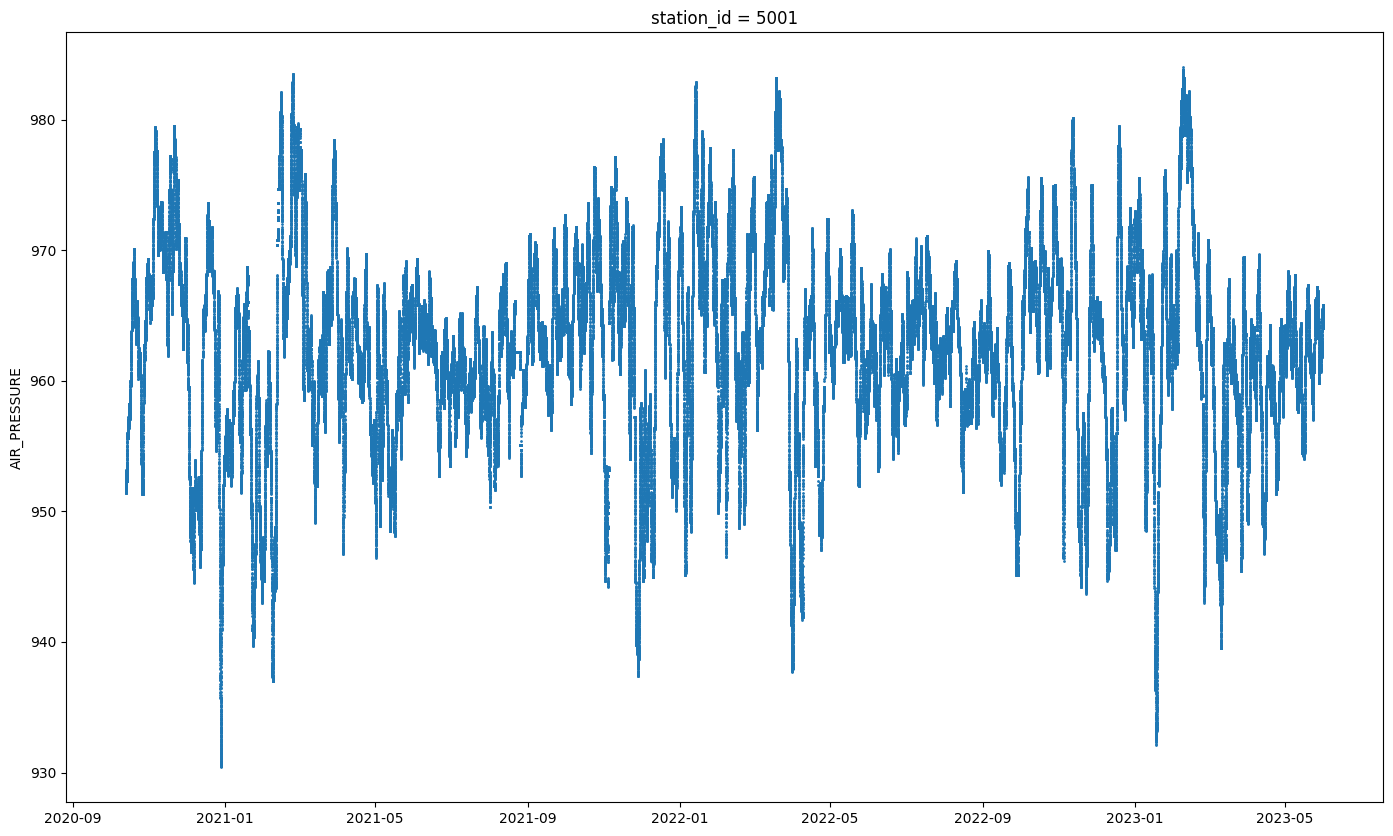

In [3]:
# plot 'AIR_PRESSURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(air_pressure_all.index, air_pressure_all['AIR_PRESSURE'],s=1)
ax.set_ylabel('AIR_PRESSURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

                           AIR_PRESSURE
2020-10-13 10:00:00+00:00    952.762500
2020-10-13 11:00:00+00:00    952.366667
2020-10-13 12:00:00+00:00    951.783333
2020-10-13 13:00:00+00:00    951.691667
2020-10-13 14:00:00+00:00    951.508333
...                                 ...
2023-05-31 17:00:00+00:00    964.141667
2023-05-31 18:00:00+00:00    964.275000
2023-05-31 19:00:00+00:00    964.991667
2023-05-31 20:00:00+00:00    965.066667
2023-05-31 21:00:00+00:00    964.900000

[23052 rows x 1 columns]


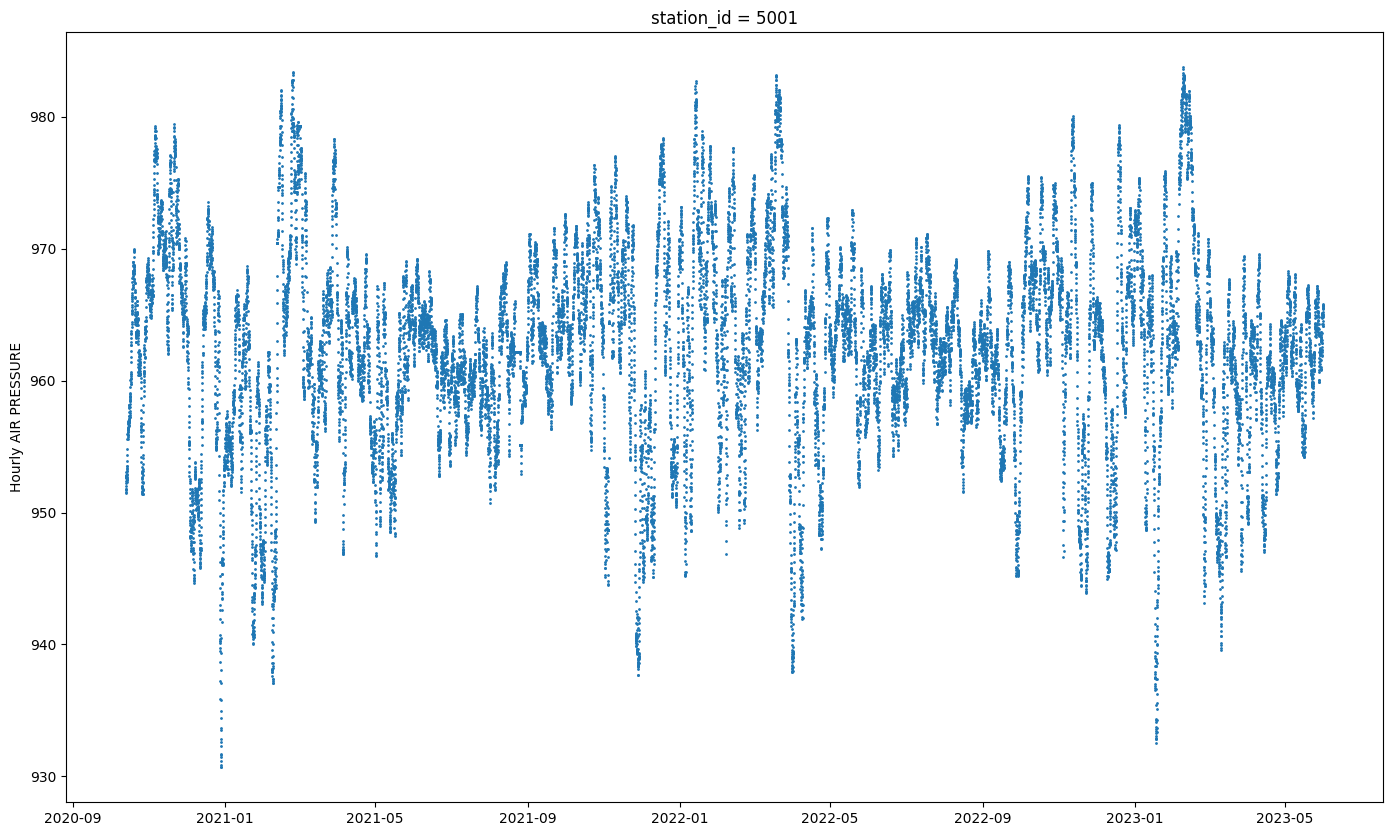

In [4]:
# hourly data
# sum the values for each hour and take the mean

str(air_pressure_all.index.dtype) # okay
air_pressure_hourly = air_pressure_all.resample('H').mean()
print(air_pressure_hourly)

# plot hourly 'AIR PRESSURE'
fig, ax = plt.subplots(figsize=(17, 10))
ax.scatter(air_pressure_hourly.index, air_pressure_hourly['AIR_PRESSURE'],s=1)
ax.set_ylabel('Hourly AIR PRESSURE')  
ax.set_title(f'station_id = {station_id}')  
plt.show()

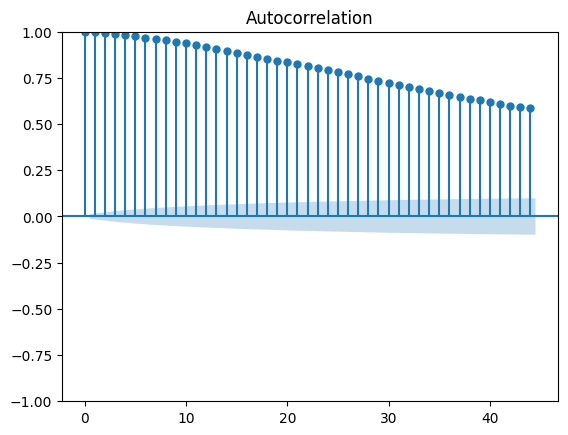

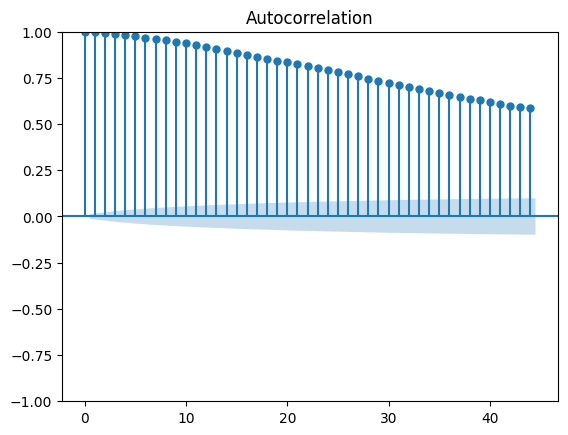

In [5]:
# ARIMA(p, d, q)

# let's look for a suggestion for d by looking at the autocorellation function (ACF) plot

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(air_pressure_hourly['AIR_PRESSURE'])

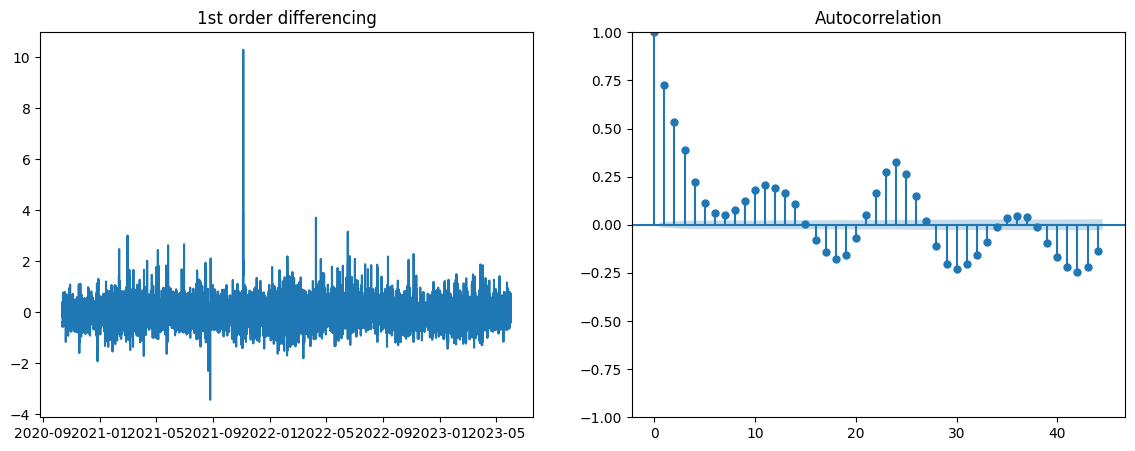

In [6]:
# first differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(air_pressure_hourly['AIR_PRESSURE'].diff())

ax2 = f.add_subplot(122)
plot_acf(air_pressure_hourly['AIR_PRESSURE'].diff().dropna(), ax=ax2)
plt.show()

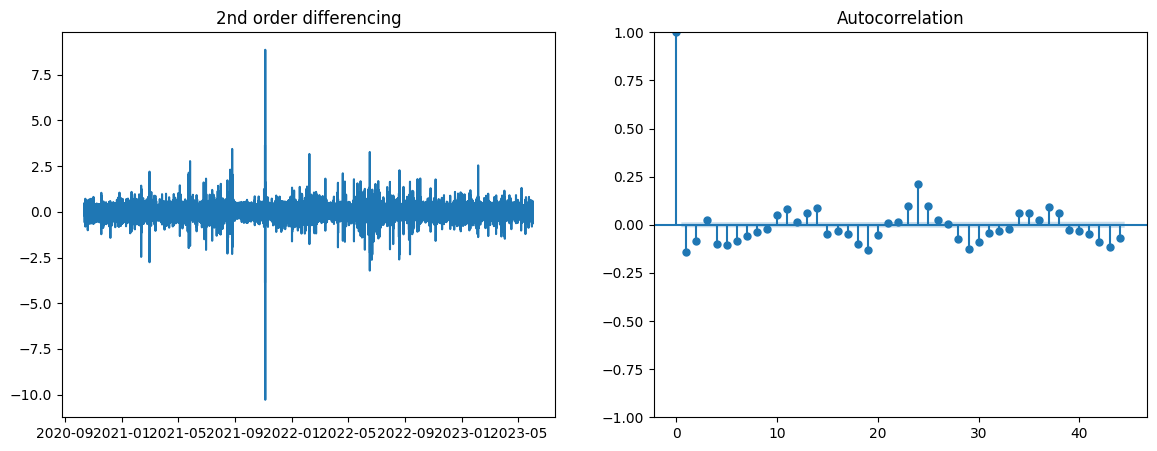

In [7]:
# second differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('2nd order differencing')
ax1.plot(air_pressure_hourly['AIR_PRESSURE'].diff().diff())

ax2 = f.add_subplot(122)
plot_acf(air_pressure_hourly['AIR_PRESSURE'].diff().diff().dropna(), ax=ax2)
plt.show()

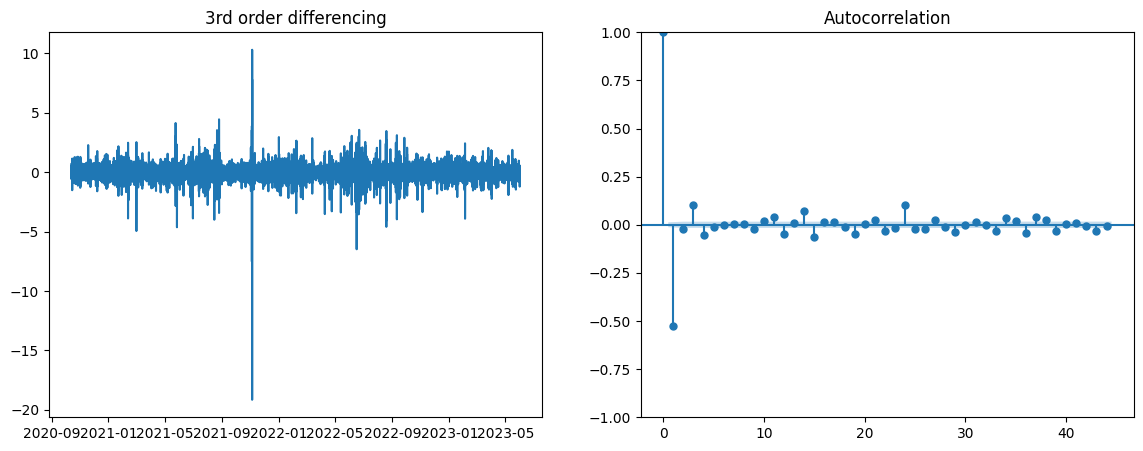

In [8]:
# third differencing and ACF

f = plt.figure(figsize=(14, 5))
ax1 = f.add_subplot(121)
ax1.set_title('3rd order differencing')
ax1.plot(air_pressure_hourly['AIR_PRESSURE'].diff().diff().diff())

ax2 = f.add_subplot(122)
plot_acf(air_pressure_hourly['AIR_PRESSURE'].diff().diff().diff().dropna(), ax=ax2)
plt.show()

For deciding the appropriate order of differencind, we can to the Augmented Dickey-Fuller test. (more about it for the report is in the air_pressure files). The ADF test aims to reject the null hypothesis that the given time-series data is non-stationary. It calculates the p-value and compares it with a threshold value or significance level of 0.05. If the p-value is less than this level, then the data is stationary; else, the differencing order is incremented by one.

In [9]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(air_pressure_hourly['AIR_PRESSURE'].dropna())
print('original data p-value:', result[1])

result = adfuller(air_pressure_hourly['AIR_PRESSURE'].diff().dropna())
print('1-diff data p-value:', result[1])

result = adfuller(air_pressure_hourly['AIR_PRESSURE'].diff().diff().dropna())
print('2-diff data p-value:', result[1])

result = adfuller(air_pressure_hourly['AIR_PRESSURE'].diff().diff().diff().dropna())
print('3-diff data p-value:', result[1])

original data p-value: 1.4072043991170616e-23
1-diff data p-value: 2.0975866515061024e-30
2-diff data p-value: 0.0
3-diff data p-value: 0.0


The data is likely stationary.

Now we will look for the best ARIMA(p,d,q) model to fit to the data.

In [13]:
# 1ST WAY OF FINDING THE BEST FIT

# ARIMA for all the hourly ambient temperature data
from pmdarima import auto_arima
stepwise_fit = auto_arima(air_pressure_hourly, trace=True,
suppress_warnings=True)
# it takes around 10 min

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=8153.709, Time=7.21 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=159548.143, Time=0.29 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=2.55 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=128344.313, Time=4.39 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=382134.307, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=11221.567, Time=4.47 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=8154.259, Time=3.11 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=8499.663, Time=33.53 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=7833.095, Time=11.36 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=9134.196, Time=5.74 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=7775.118, Time=28.44 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=7781.578, Time=34.19 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=8933.857, Time=42.44 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=7808.244, Time=12.93 sec
 ARIMA(4,0,2)(0,0,0)[0] i

                               SARIMAX Results                                
Dep. Variable:           AIR_PRESSURE   No. Observations:                23052
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -3879.451
Date:                Mon, 20 May 2024   AIC                           7774.903
Time:                        21:54:58   BIC                           7839.267
Sample:                    10-13-2020   HQIC                          7795.817
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        962.4803      0.825   1166.097      0.000     960.863     964.098
ar.L1          2.0476      0.035     58.258      0.000       1.979       2.116
ar.L2         -1.3933      0.062    -22.487      0.0

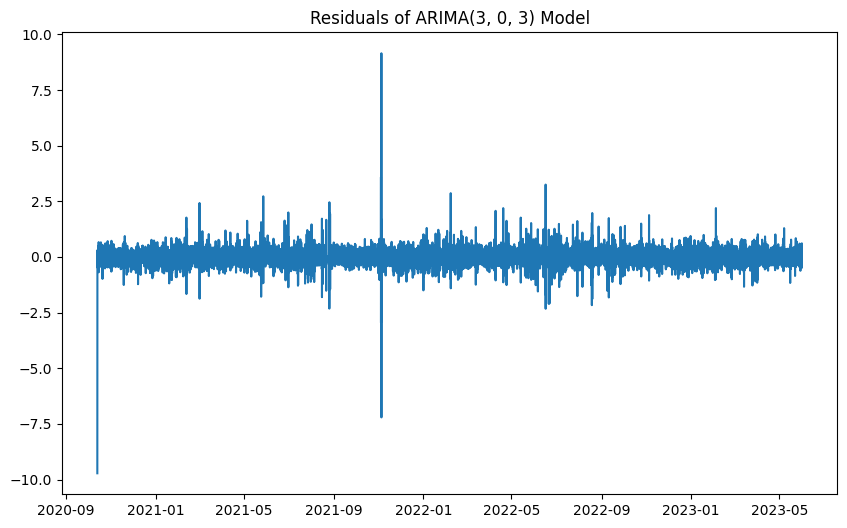

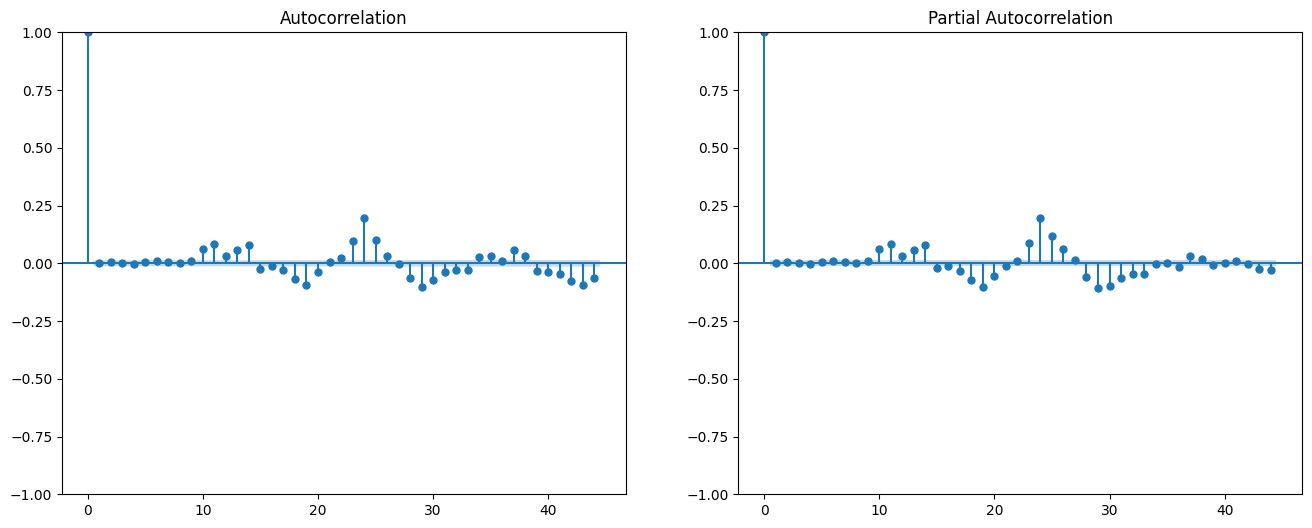

In [10]:
# fit the model 

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# fit the best model
best_model = ARIMA(air_pressure_hourly, order=(3,0,3))   # change order accordingly
best_fit = best_model.fit()

# summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{3,0,3} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0], alpha=0.05)
plot_pacf(residuals_best, ax=ax[1], alpha=0.05)
plt.show()

         Order          AIC          BIC
65   (3, 1, 5)  4950.865081  5023.274261
101  (5, 1, 5)  5046.361152  5134.861261
83   (4, 1, 5)  5098.454092  5178.908737
99   (5, 1, 3)  5388.628826  5461.038006
98   (5, 1, 2)  5601.807726  5666.171442
Best ARIMA order: (3, 1, 5)
                               SARIMAX Results                                
Dep. Variable:           AIR_PRESSURE   No. Observations:                23052
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -2466.433
Date:                Mon, 20 May 2024   AIC                           4950.865
Time:                        03:12:48   BIC                           5023.274
Sample:                    10-13-2020   HQIC                          4974.393
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------

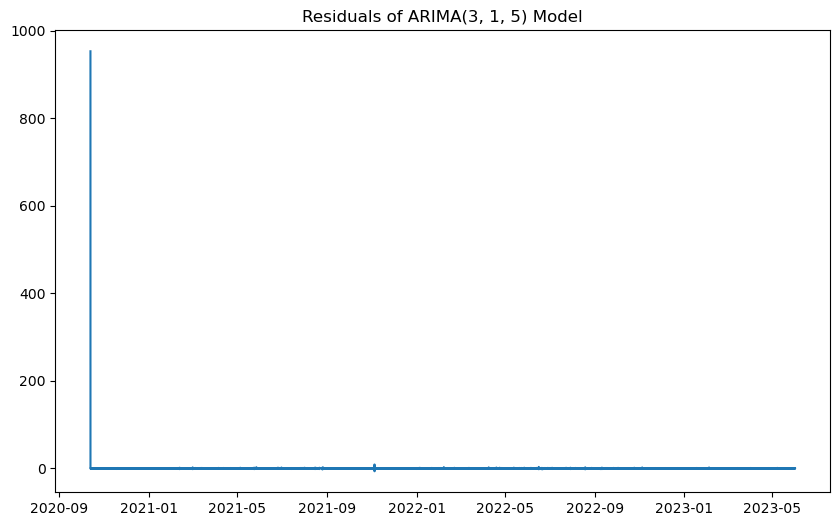

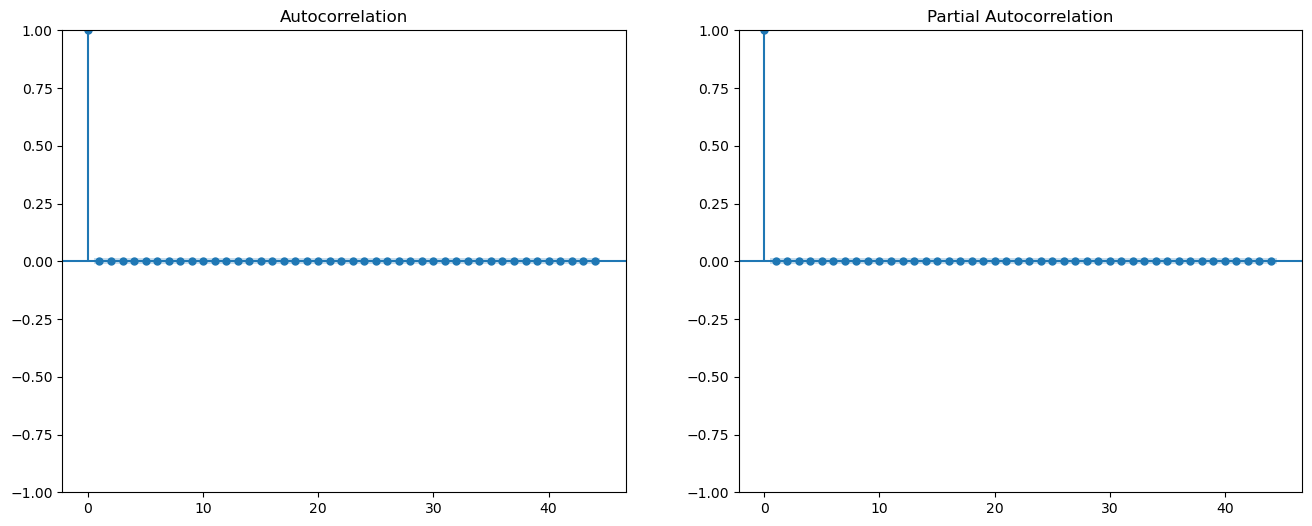

In [15]:
# 2ND WAY OF FINDING THE BEST FIT

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

# define the range for p, d, q parameters
p = range(0, 6)
d = range(0, 3)
q = range(0, 6)

# a list to store the results
results = []

# perform grid search
for i in p:
    for j in d:
        for k in q:
            order = (i, j, k)
            try:
                model = ARIMA(air_pressure_hourly, order=order)
                fit = model.fit()
                aic = fit.aic
                bic = fit.bic
                results.append((order, aic, bic))
            except:
                continue

# convert results to a DataFrame
results_df = pd.DataFrame(results, columns=['Order', 'AIC', 'BIC'])

# sort the results by AIC and BIC
results_df = results_df.sort_values(by='AIC')

# print the top 5 models
print(results_df.head())

# choose the best model based on the lowest AIC
best_order = results_df.iloc[0]['Order']
print(f"Best ARIMA order: {best_order}")

# fit the best model
best_model = ARIMA(air_pressure_hourly, order=best_order)
best_fit = best_model.fit()

# check the summary of the best model
print(best_fit.summary())

# residuals of the best model
residuals_best = best_fit.resid

# plot residuals
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(residuals_best)
plt.title(f'Residuals of ARIMA{best_order} Model')
plt.show()

# plot ACF and PACF of the residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(residuals_best, ax=ax[0])
plot_pacf(residuals_best, ax=ax[1])
plt.show()

In [11]:
# data for 2020, 2021, 2022
# fit the best model to this data
# 2 best ARIMAs: (3,0,3) and (3,1,5) - try both
# forecast the next 24 hours 
# compare forecast from ARIMA and simple model with actual values (maybe 2 simple models)
# plot forecasts, plot errors

air_pressure_20_21_22 = air_pressure_hourly.loc[(air_pressure_hourly.index.year == 2020) | (air_pressure_hourly.index.year == 2021) | (air_pressure_hourly.index.year == 2022) , 'AIR_PRESSURE']
print(air_pressure_20_21_22)

2020-10-13 10:00:00+00:00    952.762500
2020-10-13 11:00:00+00:00    952.366667
2020-10-13 12:00:00+00:00    951.783333
2020-10-13 13:00:00+00:00    951.691667
2020-10-13 14:00:00+00:00    951.508333
                                ...    
2022-12-31 19:00:00+00:00    972.766667
2022-12-31 20:00:00+00:00    972.841667
2022-12-31 21:00:00+00:00    972.908333
2022-12-31 22:00:00+00:00    972.641667
2022-12-31 23:00:00+00:00    972.475000
Freq: H, Name: AIR_PRESSURE, Length: 19430, dtype: float64


Now we will create two simple models to later compare it with the ARIMA models we fitted to the data.

Simple model: Average of the previous 3 days is the value for the next day.

We fitted ARIMA models to all the hourly data. We will fit the models to the data for just 2020, 2021 and 2022 and then forecast 1 day (24 steps into the 'future', which is the start of the year 2023).

We will then compare the models with the actual data and see which model gives the best forecast. Hopefully it is the ARIMA model.

In [12]:
# 1st simple model
# average of the previous 3 days is the value for the next day

def last_3_days_average(data, forecasted_steps):
    # Forecasts the next values based on the average of the last 3 days at the same time.
    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1) # finds out the next time step
        
        last_3_days = [
            next_time_step - pd.Timedelta(days=i) for i in range(1, 4)     # gets the same hour from the last 3 days
        ]
        
        values = [data[data.index == dt].values for dt in last_3_days] # extracts the values at the same hour from the last 3 days
        values = [val[0] if len(val) > 0 else np.nan for val in values]
        
        forecast_value = np.nanmean(values) # mean of the last 3 days
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])]) # adds the forecasted value to the data for the next iteration

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

last_3_days_average(air_pressure_20_21_22, 24)

last_3_air_pressure = last_3_days_average(air_pressure_20_21_22, 24)


In [13]:
# 2nd simple model
# today's measurement is tomorrow's forecast

def today_is_tomorrow(data, forecasted_steps):

    forecast = []

    for step in range(forecasted_steps):

        next_time_step = data.index[-1] + pd.Timedelta(hours=1)
        
        same_hour_last_day = next_time_step - pd.Timedelta(days=1)
        
        forecast_value = data.loc[same_hour_last_day]
        
        forecast.append(forecast_value)
        
        data = pd.concat([data, pd.Series([forecast_value], index=[next_time_step])])

    return pd.Series(forecast, index=[data.index[-forecasted_steps + i] for i in range(forecasted_steps)])

today_is_tomorrow(air_pressure_20_21_22, 24)

today_is_tomorrow_air_pressure = today_is_tomorrow(air_pressure_20_21_22, 24)

In [14]:
# ARIMA(3,0,3) (1st fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_303 = ARIMA(air_pressure_20_21_22, order=(3,0,3))
fit_303 = model_303.fit()

# summary of the fit
print(fit_303.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_303 = fit_303.get_forecast(steps=24)
forecast_values_303 = forecast_result_303.predicted_mean
conf_int_303 = forecast_result_303.conf_int()

print("Forecasted values:", forecast_values_303)
print("95% Confidence intervals of forecasts:", conf_int_303)

                               SARIMAX Results                                
Dep. Variable:           AIR_PRESSURE   No. Observations:                19430
Model:                 ARIMA(3, 0, 3)   Log Likelihood               -3596.445
Date:                Mon, 20 May 2024   AIC                           7208.891
Time:                        21:55:43   BIC                           7271.888
Sample:                    10-13-2020   HQIC                          7229.530
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        962.5914      0.946   1017.279      0.000     960.737     964.446
ar.L1          2.0184      0.041     48.796      0.000       1.937       2.099
ar.L2         -1.3400      0.073    -18.365      0.0

In [15]:
print(forecast_values_303)

2023-01-01 00:00:00+00:00    972.324510
2023-01-01 01:00:00+00:00    972.167020
2023-01-01 02:00:00+00:00    972.042616
2023-01-01 03:00:00+00:00    971.944136
2023-01-01 04:00:00+00:00    971.861781
2023-01-01 05:00:00+00:00    971.787799
2023-01-01 06:00:00+00:00    971.717385
2023-01-01 07:00:00+00:00    971.648104
2023-01-01 08:00:00+00:00    971.578997
2023-01-01 09:00:00+00:00    971.509868
2023-01-01 10:00:00+00:00    971.440819
2023-01-01 11:00:00+00:00    971.372018
2023-01-01 12:00:00+00:00    971.303603
2023-01-01 13:00:00+00:00    971.235660
2023-01-01 14:00:00+00:00    971.168233
2023-01-01 15:00:00+00:00    971.101337
2023-01-01 16:00:00+00:00    971.034973
2023-01-01 17:00:00+00:00    970.969134
2023-01-01 18:00:00+00:00    970.903814
2023-01-01 19:00:00+00:00    970.839006
2023-01-01 20:00:00+00:00    970.774704
2023-01-01 21:00:00+00:00    970.710905
2023-01-01 22:00:00+00:00    970.647602
2023-01-01 23:00:00+00:00    970.584793
Freq: H, Name: predicted_mean, dtype: fl

In [16]:
# ARIMA(3,1,5) (2nd fit)

# change p,d,q to the best found

from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")


# fit
model_315 = ARIMA(air_pressure_20_21_22, order=(3,1,5))
fit_315 = model_315.fit()

# summary of the fit
print(fit_315.summary())

# ARIMA forecast for 1 day (24 steps) into the future

forecast_result_315 = fit_315.get_forecast(steps=24)
forecast_values_315 = forecast_result_315.predicted_mean
conf_int_315 = forecast_result_315.conf_int()

print("Forecasted values:", forecast_values_315)
print("95% Confidence intervals of forecasts:", conf_int_315)


                               SARIMAX Results                                
Dep. Variable:           AIR_PRESSURE   No. Observations:                19430
Model:                 ARIMA(3, 1, 5)   Log Likelihood               -2397.947
Date:                Mon, 20 May 2024   AIC                           4813.895
Time:                        21:55:58   BIC                           4884.765
Sample:                    10-13-2020   HQIC                          4837.114
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.5724      0.007    385.985      0.000       2.559       2.585
ar.L2         -2.4554      0.012   -212.791      0.000      -2.478      -2.433
ar.L3          0.8404      0.007    126.084      0.0

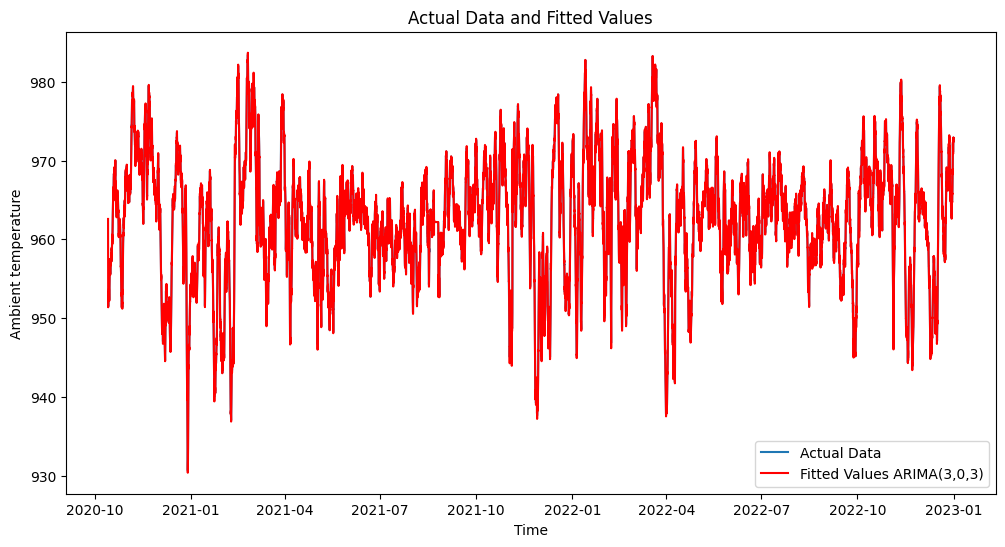

In [17]:
# plot actual data and fitted values - 1ST ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_303 = fit_303.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(air_pressure_20_21_22.index, air_pressure_20_21_22, label='Actual Data')
plt.plot(air_pressure_20_21_22.index, fitted_values_303, color='red', label='Fitted Values ARIMA(3,0,3)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ambient temperature')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

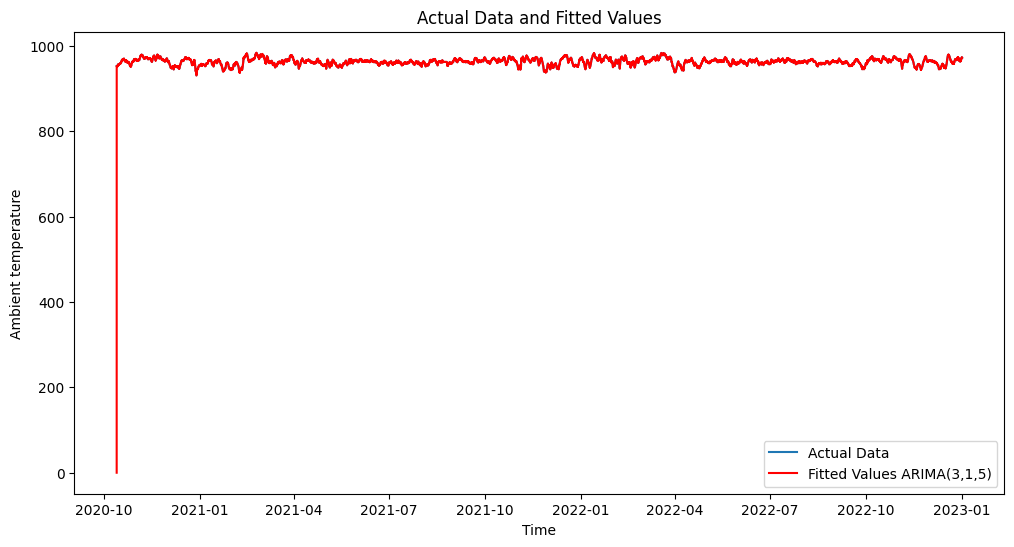

In [18]:
# plot actual data and fitted values - 2ND ARIMA
# change p,d,q to the best found

# fitted values
fitted_values_315 = fit_315.fittedvalues

plt.figure(figsize=(12,6))
plt.plot(air_pressure_20_21_22.index, air_pressure_20_21_22, label='Actual Data')
plt.plot(air_pressure_20_21_22.index, fitted_values_315, color='red', label='Fitted Values ARIMA(3,1,5)')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Ambient temperature')
plt.title('Actual Data and Fitted Values')
plt.show()

# this looks too good

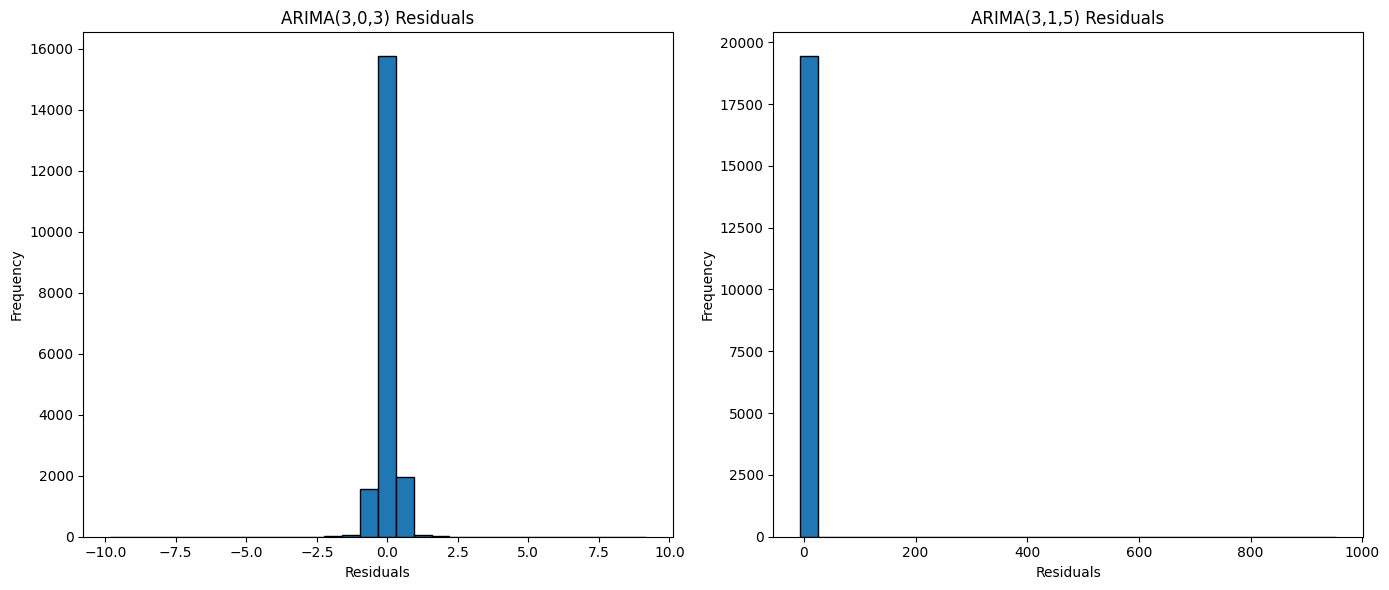

In [19]:
# comparison of the histograms

# residuals
residuals_303 = fit_303.resid
residuals_315 = fit_315.resid


plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(residuals_303, bins=30, edgecolor='k')
plt.title('ARIMA(3,0,3) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(residuals_315, bins=30, edgecolor='k')
plt.title('ARIMA(3,1,5) Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')



plt.tight_layout()
plt.show()


The residuals in a time series model are what is left over after fitting a model. The residuals are equal to the difference between the observations and the corresponding fitted values.

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will have residuals with the following properties:

1. The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
2. The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.

In [20]:
# statistical test and metricts to determine which model is better

import math 
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import shapiro

# mean of the residuals (should be 0)
mean1 = np.mean(residuals_303)
mean2 = np.mean(residuals_315)
#print(mean1, mean2)

# AIC (already done above) - writte about AIC in the report
aic1 = fit_303.aic
aic2 = fit_315.aic
#print(aic1, aic2)
# lower is better
if aic1 < aic2:
    print('ARIMA(3,0,3) is better based on AIC.')
else:
    print('ARIMA(3,1,5) is preferred based on AIC.')

# Ljung-Box test for autocorrelation - see model fit output

# BIC - see model fit output

ARIMA(3,1,5) is preferred based on AIC.


In [29]:
# actual measurements for 1 day (24 steps) into the future
press_hourly = air_pressure_hourly['AIR_PRESSURE']
actual_values_air_pressure_23 = press_hourly['2023'].head(24)
print(actual_values_air_pressure_23)

2023-01-01 00:00:00+00:00    972.391667
2023-01-01 01:00:00+00:00    972.350000
2023-01-01 02:00:00+00:00    971.916667
2023-01-01 03:00:00+00:00    971.783333
2023-01-01 04:00:00+00:00    971.691667
2023-01-01 05:00:00+00:00    971.708333
2023-01-01 06:00:00+00:00    971.616667
2023-01-01 07:00:00+00:00    972.075000
2023-01-01 08:00:00+00:00    972.166667
2023-01-01 09:00:00+00:00    972.433333
2023-01-01 10:00:00+00:00    972.358333
2023-01-01 11:00:00+00:00    971.791667
2023-01-01 12:00:00+00:00    971.225000
2023-01-01 13:00:00+00:00    971.075000
2023-01-01 14:00:00+00:00    971.291667
2023-01-01 15:00:00+00:00    971.291667
2023-01-01 16:00:00+00:00    971.758333
2023-01-01 17:00:00+00:00    972.066667
2023-01-01 18:00:00+00:00    972.258333
2023-01-01 19:00:00+00:00    972.483333
2023-01-01 20:00:00+00:00    972.541667
2023-01-01 21:00:00+00:00    972.475000
2023-01-01 22:00:00+00:00    972.283333
2023-01-01 23:00:00+00:00    972.025000
Freq: H, Name: AIR_PRESSURE, dtype: floa

                               Actual  ARIMA(3,0,3)  ARIMA(3,1,5)  \
2023-01-01 00:00:00+00:00  972.391667    972.322512    972.276926   
2023-01-01 01:00:00+00:00  972.350000    972.161301    972.086073   
2023-01-01 02:00:00+00:00  971.916667    972.032343    971.987217   
2023-01-01 03:00:00+00:00  971.783333    971.928387    972.002066   
2023-01-01 04:00:00+00:00  971.691667    971.839883    972.127813   
2023-01-01 05:00:00+00:00  971.708333    971.759393    972.331758   
2023-01-01 06:00:00+00:00  971.616667    971.682361    972.560113   
2023-01-01 07:00:00+00:00  972.075000    971.606506    972.752448   
2023-01-01 08:00:00+00:00  972.166667    971.530946    972.857898   
2023-01-01 09:00:00+00:00  972.433333    971.455505    972.848798   
2023-01-01 10:00:00+00:00  972.358333    971.380284    972.728099   
2023-01-01 11:00:00+00:00  971.791667    971.305440    972.528568   
2023-01-01 12:00:00+00:00  971.225000    971.231098    972.304011   
2023-01-01 13:00:00+00:00  971.075

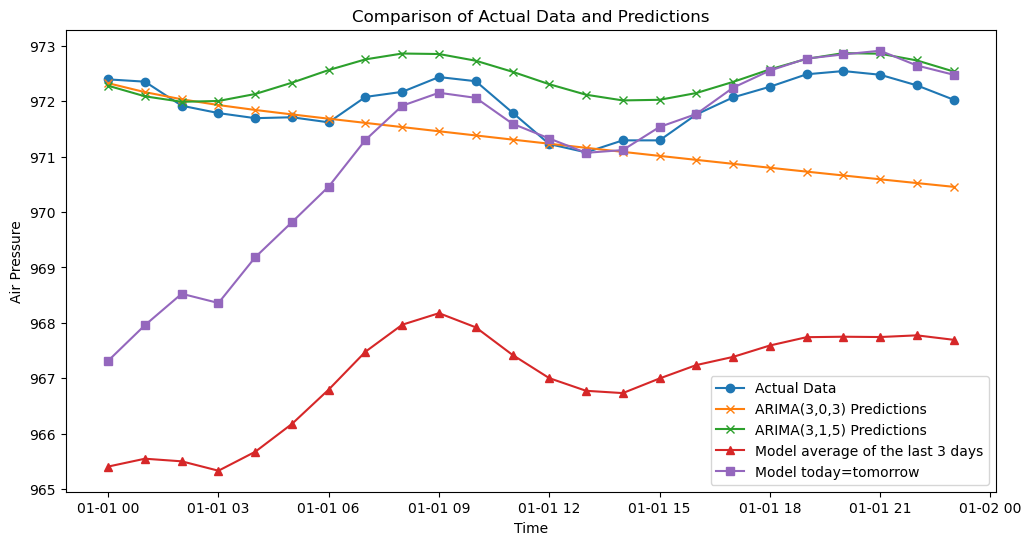

In [33]:
# comparing the models with the actual data
# change p,d,q to the best found

comparison_air_pressure = pd.DataFrame({
    'Actual': actual_values_air_pressure_23,
    'ARIMA(3,0,3)': forecast_values_303,
    'ARIMA(3,1,5)': forecast_values_315,
    'Model average of the last 3 days': last_3_air_pressure,
    'Model today=tomorrow': today_is_tomorrow_air_pressure
})

print(comparison_air_pressure)

plt.figure(figsize=(12,6))

plt.plot(comparison_air_pressure.index, comparison_air_pressure['Actual'], label='Actual Data', marker='o')
plt.plot(comparison_air_pressure.index, comparison_air_pressure['ARIMA(3,0,3)'], label='ARIMA(3,0,3) Predictions', marker='x')
plt.plot(comparison_air_pressure.index, comparison_air_pressure['ARIMA(3,1,5)'], label='ARIMA(3,1,5) Predictions', marker='x')
plt.plot(comparison_air_pressure.index, comparison_air_pressure['Model average of the last 3 days'], label='Model average of the last 3 days', marker='^')
plt.plot(comparison_air_pressure.index, comparison_air_pressure['Model today=tomorrow'], label='Model today=tomorrow', marker='s')

plt.xlabel('Time')
plt.ylabel('Air Pressure')
plt.title('Comparison of Actual Data and Predictions')
plt.legend()
plt.show()